In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
# from matplotlib.patches import Polygon
from pybaseball.plotting import spraychart

In [12]:
sqlite_file = '../wisd_data.db'

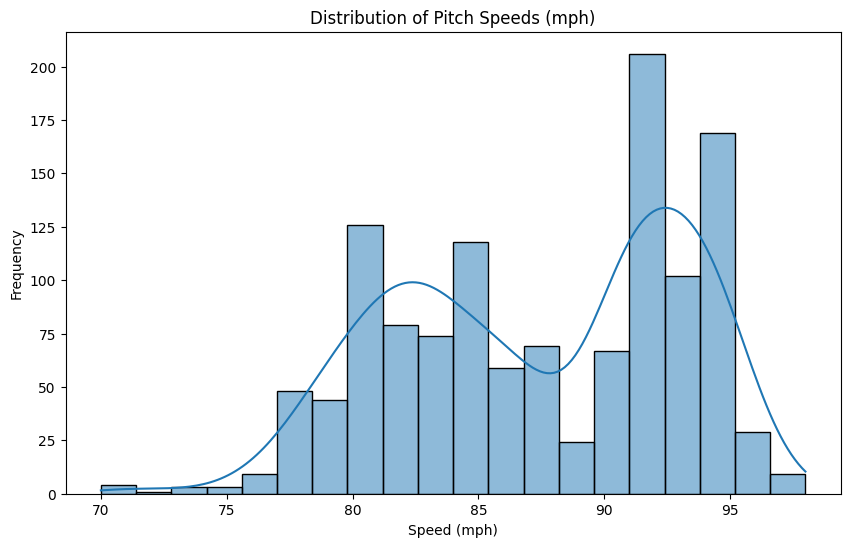

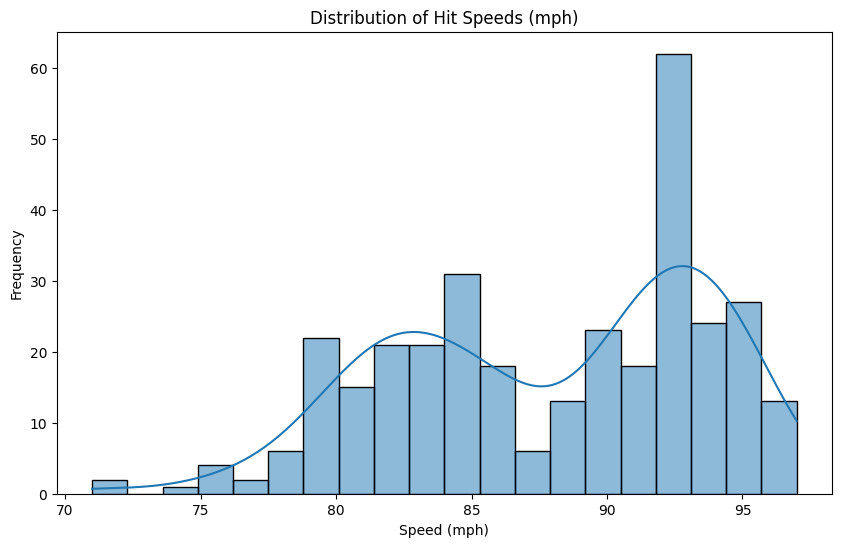

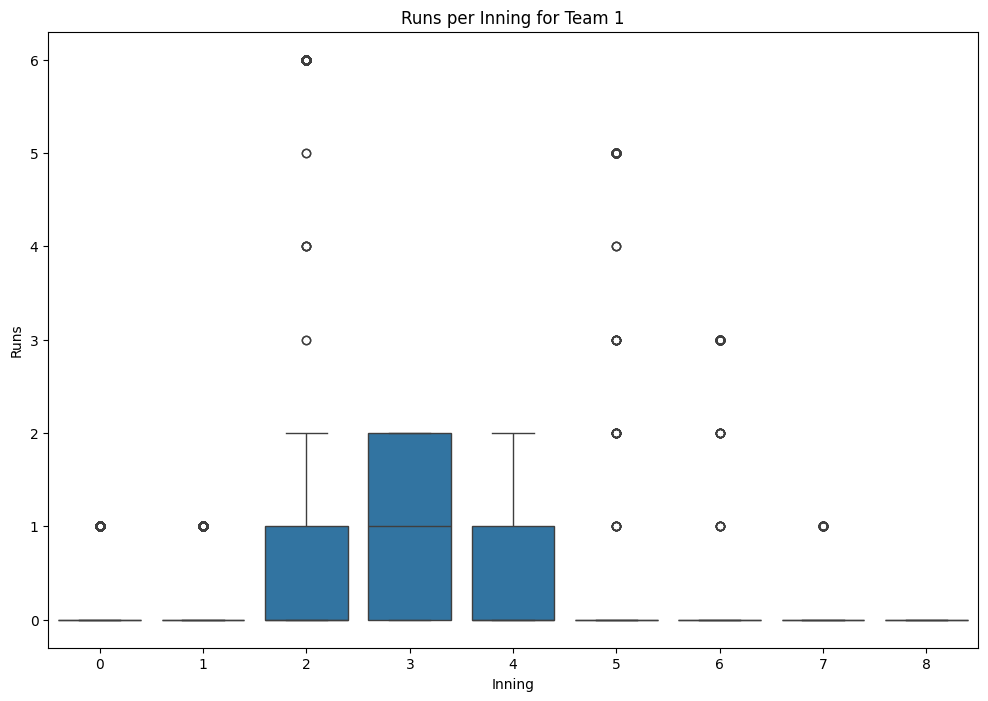

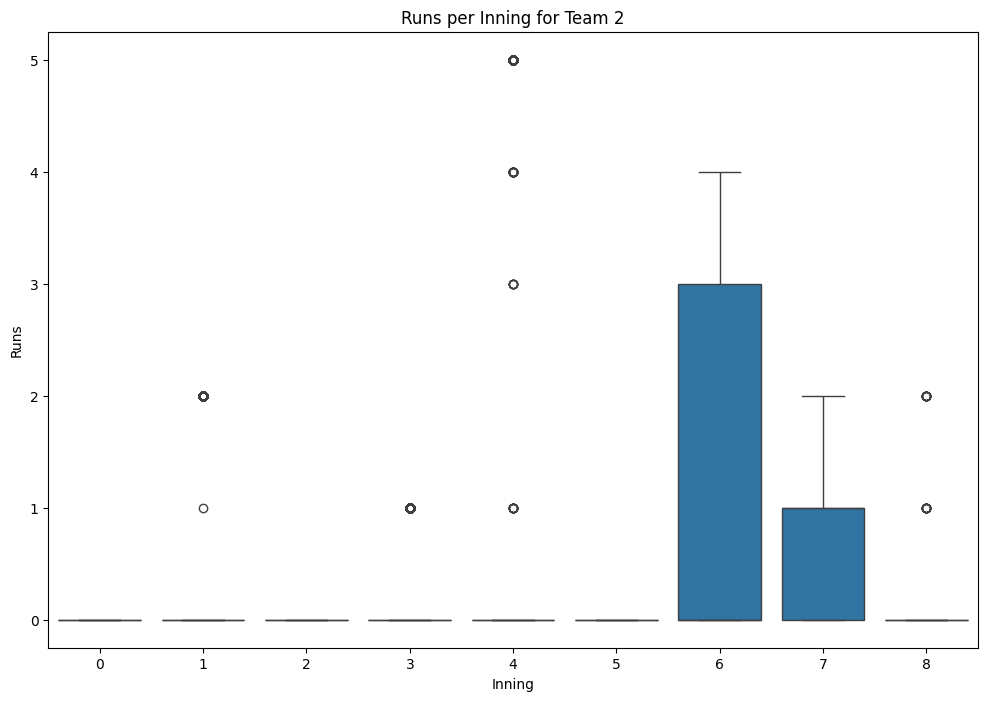

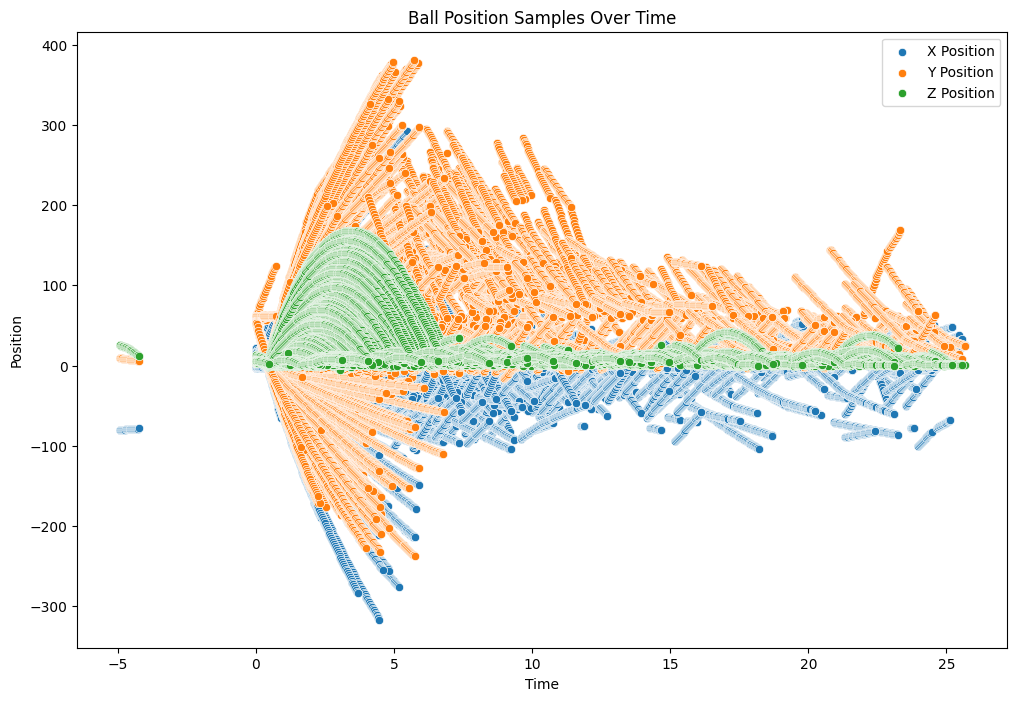

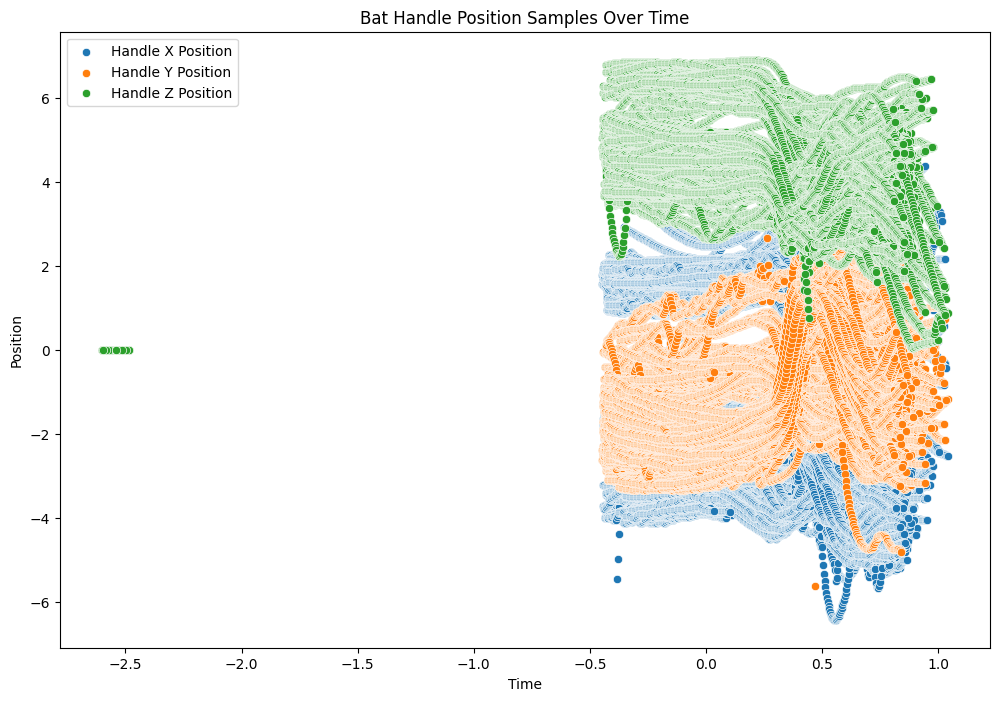

In [13]:
# Create a connection to the SQLite database
engine = create_engine(f'sqlite:///{sqlite_file}')

# Read data from SQLite database
pitch_df = pd.read_sql('pitch_data', engine)
hit_df = pd.read_sql('hit_data', engine)
score_df = pd.read_sql('score_data', engine)
events_df = pd.read_sql('events_data', engine)
ball_samples_df = pd.read_sql('ball_samples_data', engine)
bat_samples_df = pd.read_sql('bat_samples_data', engine)

# Function to create summary graphs
def create_summary_graphs():
    # Plot distribution of pitch speeds
    plt.figure(figsize=(10, 6))
    sns.histplot(pitch_df['speed_mph'], bins=20, kde=True)
    plt.title('Distribution of Pitch Speeds (mph)')
    plt.xlabel('Speed (mph)')
    plt.ylabel('Frequency')
    plt.savefig('pitch_speeds_distribution.png')
    plt.show()

    # Plot distribution of hit speeds
    plt.figure(figsize=(10, 6))
    sns.histplot(hit_df['speed_mph'], bins=20, kde=True)
    plt.title('Distribution of Hit Speeds (mph)')
    plt.xlabel('Speed (mph)')
    plt.ylabel('Frequency')
    plt.savefig('hit_speeds_distribution.png')
    plt.show()

    # Plot runs by innings
    score_df['runs_innings_team1'] = score_df['runs_innings_team1'].apply(lambda x: eval(x))
    score_df['runs_innings_team2'] = score_df['runs_innings_team2'].apply(lambda x: eval(x))
    innings_df_team1 = pd.DataFrame(score_df['runs_innings_team1'].tolist()).melt(var_name='Inning', value_name='Runs')
    innings_df_team2 = pd.DataFrame(score_df['runs_innings_team2'].tolist()).melt(var_name='Inning', value_name='Runs')

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Inning', y='Runs', data=innings_df_team1)
    plt.title('Runs per Inning for Team 1')
    plt.xlabel('Inning')
    plt.ylabel('Runs')
    plt.savefig('runs_per_inning_team1.png')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Inning', y='Runs', data=innings_df_team2)
    plt.title('Runs per Inning for Team 2')
    plt.xlabel('Inning')
    plt.ylabel('Runs')
    plt.savefig('runs_per_inning_team2.png')
    plt.show()

    # Plot ball position samples over time
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='time', y='pos_x', data=ball_samples_df, label='X Position')
    sns.scatterplot(x='time', y='pos_y', data=ball_samples_df, label='Y Position')
    sns.scatterplot(x='time', y='pos_z', data=ball_samples_df, label='Z Position')
    plt.title('Ball Position Samples Over Time')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()
    plt.savefig('ball_position_samples.png')
    plt.show()

    # Plot bat handle position samples over time
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='time', y='handle_pos_x', data=bat_samples_df, label='Handle X Position')
    sns.scatterplot(x='time', y='handle_pos_y', data=bat_samples_df, label='Handle Y Position')
    sns.scatterplot(x='time', y='handle_pos_z', data=bat_samples_df, label='Handle Z Position')
    plt.title('Bat Handle Position Samples Over Time')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()
    plt.savefig('bat_handle_position_samples.png')
    plt.show()

# Generate summary graphs
create_summary_graphs()


In [31]:
from matplotlib.patches import Polygon
from matplotlib.path import Path
from pybaseball.plotting import plot_stadium
from pybaseball import spraychart
import numpy as np

In [124]:
event_id = '93ac9ebe-19d9-4699-9bf3-30f31e361ccb'
ball_samples_df = pd.read_sql('ball_samples_data', engine)

# Filter data for the given event ID
event_data = ball_samples_df[ball_samples_df['pitch_eventId'] == event_id]

# Ensure the data is sorted by time
event_data = event_data.sort_values(by='time')

def crop_dataframe_after_gap(df, time_col, gap_threshold=2):
    """
    Crop the dataframe after a significant gap in the time column.

    :param df: pandas DataFrame containing the event data
    :param time_col: name of the column containing time data
    :param gap_threshold: threshold for determining a significant gap
    :return: cropped DataFrame
    """
    # Calculate the differences between consecutive time points
    time_diffs = df[time_col].diff()

    gap_indices = time_diffs[time_diffs > gap_threshold].index

    if not gap_indices.empty:
        # If there is a gap, find the first index where the gap occurs
        gap_index = gap_indices[0]
        # Crop the dataframe after the gap
        cropped_df = df.loc[:gap_index-1]
    else:
        # If no gaps are found, return the original dataframe
        cropped_df = df

    return cropped_df

def crop_dataframe_after_discontinuity(df, x_col, y_col, distance_threshold=10):
    """
    Crop the dataframe after a significant discontinuity in the x-y journey of the ball.

    :param df: pandas DataFrame containing the event data
    :param x_col: name of the column containing x positions
    :param y_col: name of the column containing y positions
    :param distance_threshold: threshold for determining a significant discontinuity
    :return: cropped DataFrame
    """
    # Calculate the Euclidean distances between consecutive points
    distances = np.sqrt(np.diff(df[x_col])**2 + np.diff(df[y_col])**2)
    
    # Find the index where the distance is greater than the threshold
    discontinuity_index = np.argmax(distances > distance_threshold)

    # Check if a discontinuity was found
    if distances[discontinuity_index] > distance_threshold:
        # Crop the dataframe before the discontinuity
        cropped_df = df.iloc[:discontinuity_index+1]
    else:
        # No discontinuity found, return the original dataframe
        cropped_df = df

    return cropped_df

def process_event(df):
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='time', inplace=True)
    df = crop_dataframe_after_gap(df, 'time')
    df = crop_dataframe_after_discontinuity(df, 'pos_x', 'pos_y')
    return df


In [133]:
final_positions = []
for eventId, grp in ball_samples_df.groupby('hit_eventId'):
    event_data = process_event(grp)
    final_pos = event_data.tail(1)[['pos_x','pos_y']].values[0]
    final_positions.append(final_pos)

In [145]:
df

,hc_x,hc_y,team,player_name,events
0,47.281978,266.467034,Team,Player,Single
1,-45.814095,376.373789,Team,Player,Single
2,63.821563,197.760407,Team,Player,Single
3,60.041734,65.956425,Team,Player,Single
4,-14.943899,-20.036415,Team,Player,Single
...,...,...,...,...,...
325,-70.284747,36.744038,Team,Player,Single
326,-10.118731,95.357931,Team,Player,Single
327,183.331196,126.092794,Team,Player,Single
328,1.048966,133.505310,Team,Player,Single


In [151]:
from pybaseball import statcast_batter, spraychart

data = statcast_batter('2019-05-01', '2019-07-01', 514888)
sub_data = data[data['home_team'] == 'HOU']

Gathering Player Data


In [154]:
sub_data[['pfx_x',
       'pfx_z']]

,pfx_x,pfx_z
0,-1.05,-0.98
1,-0.92,-1.06
2,1.49,0.76
3,0.03,0.64
4,0.58,1.52
...,...,...
221,0.02,1.30
222,-0.57,1.30
223,-0.46,1.35
224,1.19,-0.38


In [153]:
sub_data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

/Users/vrose/Desktop/Main/WISD/VENV/lib/python3.12/site-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]
/Users/vrose/Desktop/Main/WISD/VENV/lib/python3.12/site-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


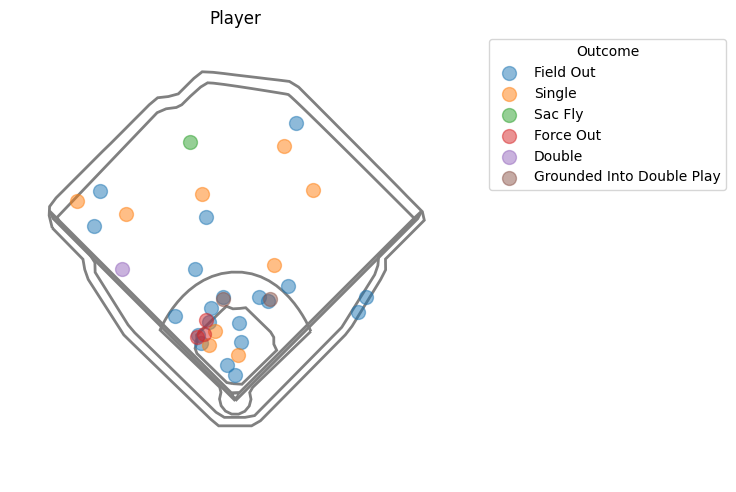

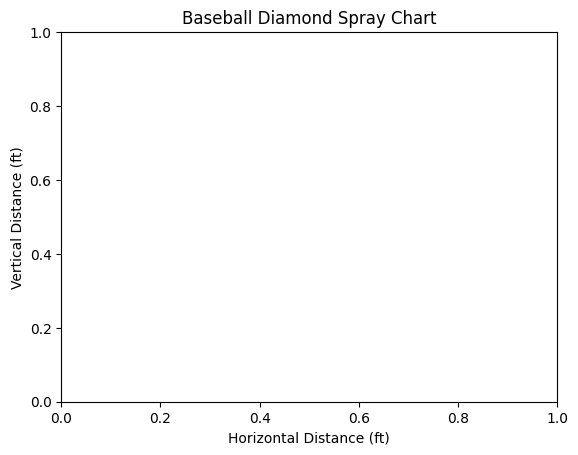

In [155]:
# Convert the list of data points to a DataFrame
df = pd.DataFrame(final_positions, columns=['hc_x', 'hc_y'])

# Adding necessary columns for spraychart
df['team'] = 'bos'  # Use a valid team abbreviation
df['player_name'] = 'Player'
df['events'] = 'Single'  # Replace with actual event type if available

# Plot the spray chart using pybaseball
spraychart(sub_data, 'phillies', 'Player')  # Ensure 'bos' is a valid team abbreviation

plt.title('Baseball Diamond Spray Chart')
plt.xlabel('Horizontal Distance (ft)')
plt.ylabel('Vertical Distance (ft)')
plt.show()

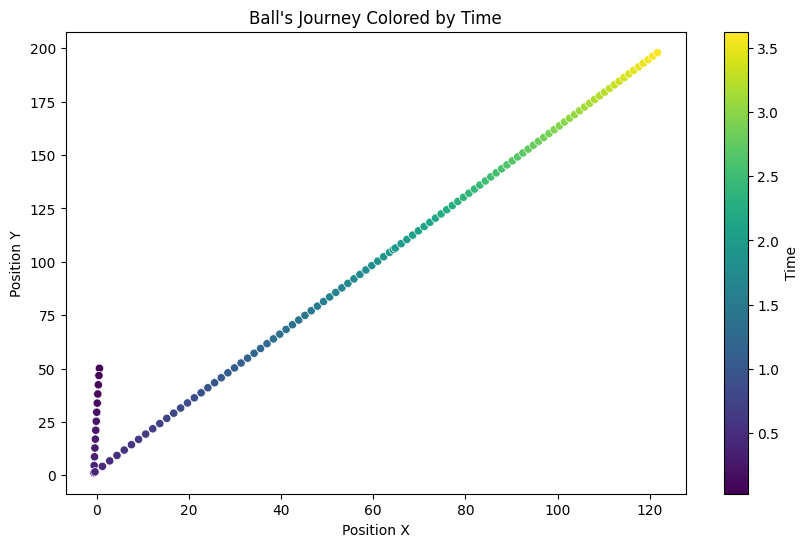

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter = sns.scatterplot(x='pos_x', y='pos_y', hue='time', palette='viridis', data=event_data, legend=None, ax=ax)
plt.title("Ball's Journey Colored by Time")
plt.xlabel('Position X')
plt.ylabel('Position Y')

# Create the color bar
norm = plt.Normalize(event_data['time'].min(), event_data['time'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Time')
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


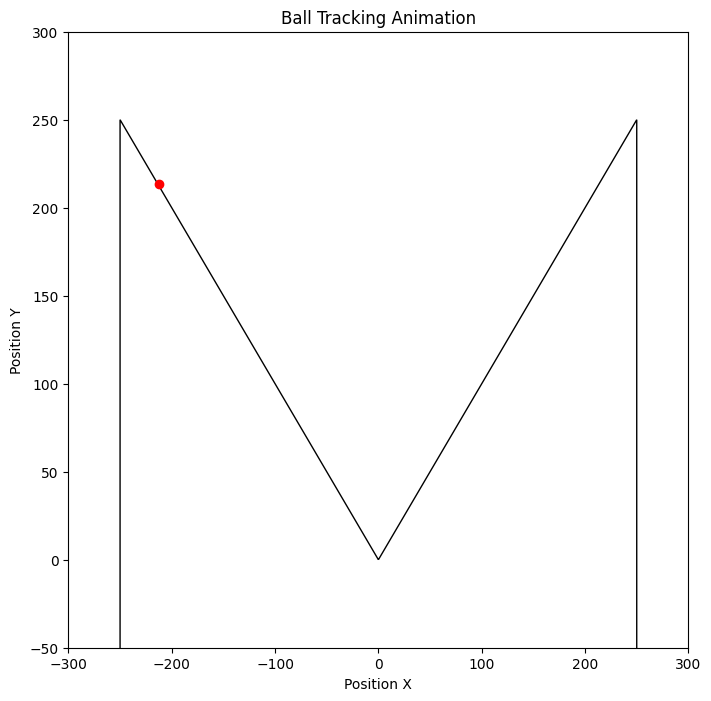

In [75]:
from matplotlib.animation import FuncAnimation


# Check if event_data is not empty
if event_data.empty:
    raise ValueError(f"No data found for eventId {event_id}")

# Plotting the animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-300, 300)
ax.set_ylim(-50, 300)
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_title('Ball Tracking Animation')

# Define the field
field_polygon = plt.Polygon(
    [[0, 0], [250, 250], [250, -250], [-250, -250], [-250, 250], [0, 0]],
    closed=True, fill=False, edgecolor='black'
)
ax.add_patch(field_polygon)

ball, = ax.plot([], [], 'ro')  # Red dot for the ball

def init():
    ball.set_data([], [])
    return ball,

def update(frame):
    ball.set_data([event_data['pos_x'].iloc[frame]], [event_data['pos_y'].iloc[frame]])
    return ball,

ani = FuncAnimation(fig, update, frames=len(event_data), init_func=init, blit=False)

# Save the animation
ani.save(f'ball_tracking_animation_{event_id}_cropped.gif', writer='imagemagick', fps=20)

plt.show()


In [41]:
final_positions

,pitch_eventId,hit_eventId,time,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,acc_x,acc_y,acc_z,speed_mph,speed_kph,speed_mps,spin_rpm,hc_x,hc_y,events
32552,1dbb15ec-5f9b-46de-9de1-d3d145f7c75b,00ef6ccd-019c-4334-aa50-e3015d54580b,13.526092,-7.650312,83.811816,6.886291,NaN,NaN,NaN,NaN,NaN,NaN,92.0,147.0,41.0,2460,-7.650312,83.811816,Hit
40687,f2e09f4e-b0dc-4e12-883e-15a12cc958e6,015212e9-ef9e-4428-9220-a1c6efa40639,23.964561,-5.583287,68.628896,4.625931,NaN,NaN,NaN,NaN,NaN,NaN,82.0,132.0,37.0,2140,-5.583287,68.628896,Hit
1676,5cb811b3-68fa-43fa-817b-3a207e419880,03a44a11-3b71-489f-b226-07070aec18e3,15.300459,-6.355004,62.006362,4.426414,NaN,NaN,NaN,NaN,NaN,NaN,80.0,128.0,36.0,2330,-6.355004,62.006362,Hit
14185,f0b55d56-c0ff-46e0-a531-898dc3e866c0,03d202a3-414a-4272-942e-45ab13ccc5d3,4.578208,60.041734,65.956425,2.722914,NaN,NaN,NaN,NaN,NaN,NaN,85.0,137.0,38.0,2350,60.041734,65.956425,Hit
12285,74f33e28-6ed1-4e9e-81f2-8127c902073e,057c0d71-fb0b-47e8-9f06-f4a7f546a98f,5.113687,0.340962,55.438839,5.013364,NaN,NaN,NaN,NaN,NaN,NaN,94.0,151.0,42.0,1710,0.340962,55.438839,Hit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21727,87b23d45-f752-4771-9363-351a5062e500,fd26fe6f-0c6e-4fc0-9ed5-622ae011c2c5,16.505436,-14.585111,49.831866,3.482341,NaN,NaN,NaN,NaN,NaN,NaN,80.0,129.0,36.0,2100,-14.585111,49.831866,Hit
24946,a5dfaaf5-9e38-4f97-9f85-00616c34c0c6,fd84ef68-8996-4551-9187-d878e6624899,5.035915,-2.372032,52.123729,5.562036,NaN,NaN,NaN,NaN,NaN,NaN,81.0,130.0,36.0,2440,-2.372032,52.123729,Hit
20319,06da6e40-8d95-4adf-8b89-cd209c1dfff2,fe158e45-86c6-47b7-9a8c-385f6814065e,4.190658,33.114949,92.827716,7.681307,46.987972,-50.494125,-1.486693,-13.164811,12.975378,-22.275024,82.0,131.0,36.0,2340,33.114949,92.827716,Hit
38759,73f3e015-c57d-4ae0-8922-70ba79a7c997,fe851387-9234-4248-b3f0-b5301a0d41b4,8.069992,2.302469,42.118033,4.792838,NaN,NaN,NaN,NaN,NaN,NaN,85.0,136.0,38.0,2680,2.302469,42.118033,Hit


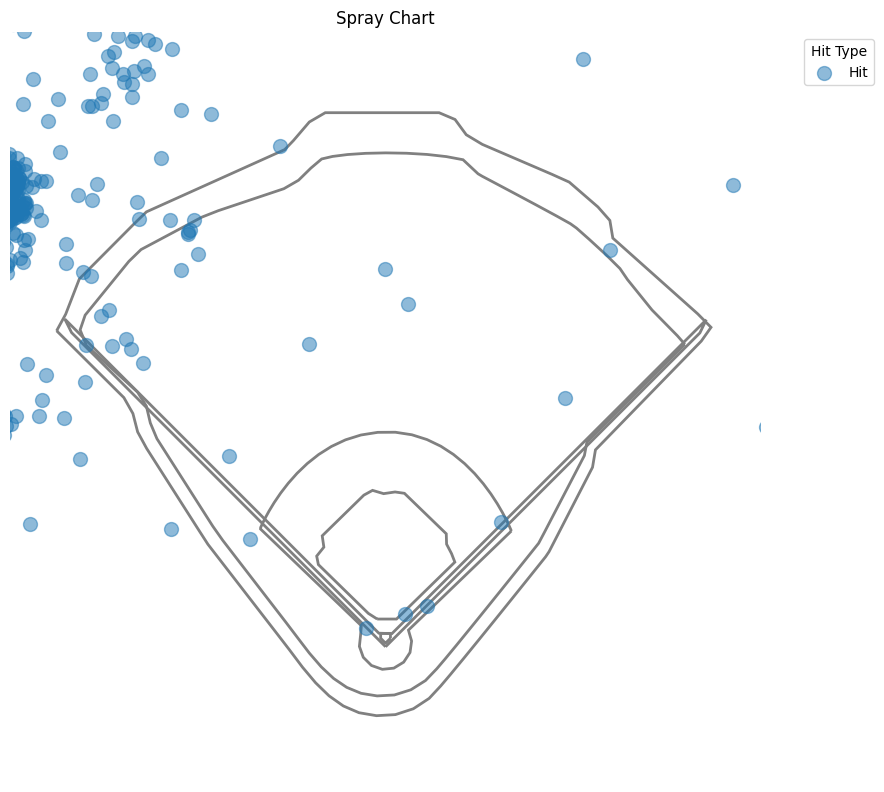

<Axes: title={'center': 'Spray Chart'}>

In [40]:



# Read data from SQLite database
hit_df = pd.read_sql('hit_data', engine)
ball_samples_df = pd.read_sql('ball_samples_data', engine)

# Merge ball samples with hit data to get only the final positions of hits
merged_df = ball_samples_df.merge(hit_df, left_on='hit_eventId', right_on='hit_eventId')

# Extract final positions (assuming highest time value per hit)
final_positions = merged_df.loc[merged_df.groupby('hit_eventId')['time'].idxmax()]

# Prepare data for spraychart function
final_positions['hc_x'] = final_positions['pos_x']
final_positions['hc_y'] = final_positions['pos_y']
final_positions['events'] = 'Hit'

# Optionally, you can add more context to the 'events' column based on your data

# Plot the spray chart using pybaseball
spraychart(
    final_positions,
    team_stadium='brewers',  # Change this to the desired stadium
    title='Spray Chart',
    size=100,
    colorby='events',
    legend_title='Hit Type',
    width=800,
    height=800
)
